# Scoring

In [176]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

EMBEDDING_DIM = 1024
REDUCED_DIM = 128  # Dimension after encoder
HIDDEN_DIM = 128  # Dimension in matrix factorization space
ATTENTION_DIM = 128  # Dimension for attention layer
BATCH_SIZE = 100
EPOCHS = 30
L2_REGULARIZATION = 0.03  # Regularization strength

In [171]:
import json

embedding_lookup = {}
def readEmbeddings(input_file):
    with open(input_file, 'r') as infile:
        for line in infile:
            item = json.loads(line)
            embedding_lookup[item['title']] = item['embedding']

readEmbeddings("files/embedding.txt")

In [172]:
# Preprocessing
import pandas as pd

df_og = pd.read_csv("files/normalized_politicians.csv")
df = df_og.copy()

politician_names = df['politician'].unique()
politician_to_id = {name: idx for idx, name in enumerate(politician_names)}

source_names = df['source'].unique()
source_to_id = {name: idx for idx, name in enumerate(source_names)}

def sentiment_to_id(sentiment):
    if sentiment == "POSITIVE":
        return 1
    elif sentiment == "NEUTRAL":
        return 0
    else:
        return -1

df['politician'] = df['politician'].map(politician_to_id)
df['source'] = df['source'].map(source_to_id)
df['sentiment'] = df['sentiment'].map(sentiment_to_id)

df

,title,description,sentiment,source,politician
0,Reality check? Marcos admits flood control inf...,"After saying that over 5,500 flood control pro...",0,0,0
1,Marcos declares November 4 as day of national ...,'The national flag shall be flown at half-mast...,1,0,0
2,Marcos declares November 4 as day of national ...,'The national flag shall be flown at half-mast...,1,0,1
3,Marcos says he'd 'rather not' comment on Sara ...,"Today's headlines: Marcos & Duterte, Lebron Ja...",0,0,2
4,Marcos says he'd 'rather not' comment on Sara ...,"Today's headlines: Marcos & Duterte, Lebron Ja...",-1,0,3
...,...,...,...,...,...
242,President Marcos Jr. orders acceleration of co...,"PRESIDENT Ferdinand Bongbong Marcos, Jr. is pu...",1,3,100
243,"Pagkikita ni VP Sara at Leni Robredo, maitutur...",NAGKITA noong nakaraang linggo si Vice Preside...,1,3,101
244,"Pagkikita ni VP Sara at Leni Robredo, maitutur...",NAGKITA noong nakaraang linggo si Vice Preside...,1,3,17
245,"Pagkikita ni VP Sara at Leni Robredo, maitutur...",NAGKITA noong nakaraang linggo si Vice Preside...,1,3,7


In [173]:

class PoliticianDataset(Dataset):
    def __init__(self, data, embeddings):
        self.data = data
        self.embedding_lookup = embeddings

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        embeddings = self.embedding_lookup[row["title"]]
        article_embedding = torch.tensor(embeddings, dtype=torch.float32)

        politician = row["politician"]
        source = row["source"]
        sentiment = row["sentiment"]

        return article_embedding, politician, source, sentiment, idx

dataset = PoliticianDataset(df, embedding_lookup)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


# Test
dataset[3]

(tensor([ 0.3150, -0.4819, -1.0585,  ..., -1.5969, -1.1188, -0.5643]),
 np.int64(2),
 np.int64(0),
 np.int64(0),
 3)

In [177]:

num_politicians = df['politician'].nunique()
num_sources  = df['source'].nunique()
num_articles = df['title'].nunique()

# Define the Model
class MatrixFactorizationModel(nn.Module):
    def __init__(self, num_politicians, num_sources):
        super(MatrixFactorizationModel, self).__init__()
        
        # Embeddings
        self.u = nn.Parameter(torch.zeros(1))  # Global bias
        self.i_pol = nn.Embedding(num_politicians, 1)  # Bias for politicians
        self.i_source = nn.Embedding(num_sources, 1)  # Bias for sources
        
        # Article encoder: reduce dimensions from 1024 to reduced_dim
        self.encoder = nn.Sequential(
            nn.Linear(EMBEDDING_DIM, REDUCED_DIM),
            nn.ReLU(),
        )
        
        # Attention layer for processed article embedding
        self.attention = nn.Sequential(
            nn.Linear(REDUCED_DIM, ATTENTION_DIM),
            nn.Tanh(),
            nn.Linear(ATTENTION_DIM, 1),
            nn.Softmax(dim=1),
        )

        # Matrix factorization parameters for politicians, and sources
        self.u_pol = nn.Embedding(num_politicians, HIDDEN_DIM)
        self.u_source = nn.Embedding(num_sources, HIDDEN_DIM)

    def forward(self, article_embedding, politician, source):
        # Encode article title embedding
        reduced_embedding = self.encoder(article_embedding)
        
        # Apply attention
        attention_weights = self.attention(reduced_embedding)
        u_article = attention_weights * reduced_embedding
                
        # Get factors for politician and source
        u_pol = self.u_pol(politician)
        u_source = self.u_source(source)

        score = (
            self.u
            + self.i_pol(politician).sum(dim=1)
            + self.i_source(source).sum(dim=1)
            + ( u_article * u_pol ).sum(dim=1)
            + ( u_source * u_pol ).sum(dim=1)
        )
        return score

model = MatrixFactorizationModel(num_politicians, num_sources).cuda()

In [179]:
# Use L2 regularization (weight decay) in the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=L2_REGULARIZATION)
criterion = nn.MSELoss()

# Custom regularization loss function
def regularized_loss(pred, target, model, l2_lambda=L2_REGULARIZATION):
    base_loss = criterion(pred, target)
    
    # Add regularization terms for embeddings
    l2_reg = (
        torch.norm(model.i_pol.weight, 2)
        + torch.norm(model.i_source.weight, 2)
        + torch.norm(model.u_pol.weight, 2)
        + torch.norm(model.u_source.weight, 2)
    )
    return base_loss

# Training loop
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for article_embedding, politician, source, sentiment, idxs in dataloader:

        article_embedding = article_embedding.cuda()
        politician = politician.cuda()
        source = source.cuda()
        sentiment = sentiment.float().cuda()

        optimizer.zero_grad()
        output = model(article_embedding, politician, source)
        # Compute regularized loss
        loss = regularized_loss(output, sentiment, model)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss/len(dataloader)}")

# Save the trained model
torch.save(model.state_dict(), "files/matrix_factorization_model.pth")

Epoch 1/30, Loss: 3.0282112366209426
Epoch 2/30, Loss: 7.845983982086182
Epoch 3/30, Loss: 5.337206522623698
Epoch 4/30, Loss: 4.200576464335124
Epoch 5/30, Loss: 3.5961223443349204
Epoch 6/30, Loss: 2.358307401339213
Epoch 7/30, Loss: 2.029019514719645
Epoch 8/30, Loss: 1.4877745310465496
Epoch 9/30, Loss: 1.2515002886454265
Epoch 10/30, Loss: 1.1314293146133423
Epoch 11/30, Loss: 0.8796209096908569
Epoch 12/30, Loss: 0.6552258729934692
Epoch 13/30, Loss: 0.720863918463389
Epoch 14/30, Loss: 0.5707704921563467
Epoch 15/30, Loss: 0.4635980228583018
Epoch 16/30, Loss: 0.301259050766627
Epoch 17/30, Loss: 0.28951189418633777
Epoch 18/30, Loss: 0.24320062001546225
Epoch 19/30, Loss: 0.21090389788150787
Epoch 20/30, Loss: 0.15391506254673004
Epoch 21/30, Loss: 0.16507152219613394
Epoch 22/30, Loss: 0.1585910071929296
Epoch 23/30, Loss: 0.126743217309316
Epoch 24/30, Loss: 0.11529608567555745
Epoch 25/30, Loss: 0.08509123573700587
Epoch 26/30, Loss: 0.109809214870135
Epoch 27/30, Loss: 0.08

In [180]:
# Test the model

model.eval()
with torch.no_grad():
    for article_embedding, politician, source, sentiment, idxs in dataloader:

        article_embedding = article_embedding.cuda()
        politician = politician.cuda()
        source = source.cuda()
        sentiment = sentiment.float().cuda()

        output = model(article_embedding, politician, source)
        
        for i in range(len(output)):
            idx = int(idxs[i])
            article_title = df_og.iloc[idx]["title"]
            politician_name = df_og.iloc[idx]["politician"]
            source_name = df_og.iloc[idx]["source"]
            sentiment_name = df_og.iloc[idx]["sentiment"]
            predicted_sentiment = output[i]
            
            print(f"Article: {article_title}")
            print(f"Politician: {politician_name}")
            print(f"Source: {source_name}")
            print(f"Sentiment: {sentiment_name}")
            print(f"Predicted Sentiment: {predicted_sentiment}")
            print()

Article: COC filing day 4, local races: Leni Robredo’s Team Naga, dynasty challengers
Politician: Leni Robredo
Source: www.rappler.com
Sentiment: POSITIVE
Predicted Sentiment: 0.9831380844116211

Article: Sen. Risa Hontiveros, pinayuhang mag-aral ng batas bago manira vs kay Pastor Apollo C. Quiboloy
Politician: Risa Hontiveros
Source: smninewschannel.com
Sentiment: POSITIVE
Predicted Sentiment: 1.4292354583740234

Article: Rappler Recap: Sara Duterte, Risa Hontiveros clash during Senate budget hearing
Politician: Grace Poe
Source: www.rappler.com
Sentiment: NEUTRAL
Predicted Sentiment: -0.008949756622314453

Article: Leni Robredo announces Naga City mayoral bid
Politician: Jess Albeus
Source: www.gmanetwork.com
Sentiment: POSITIVE
Predicted Sentiment: 0.9281258583068848

Article: Who helped Alice Guo flee from the Philippines?
Politician: Guo Hua Ping
Source: www.rappler.com
Sentiment: POSITIVE
Predicted Sentiment: 0.8065557479858398

Article: Leni Robredo announces Naga City mayor bid

102
('Jericho Petilla', 2.0964572429656982)
('Leni Robredo', 1.8627315759658813)
('Gloria Macapagal Arroyo', 1.699018955230713)
('J-Hope', 1.6453092098236084)
('Diana Mackey', 1.348565697669983)
('Jejomar Binay', 1.1170185804367065)
('Martin Romualdez', 1.007549524307251)
('Risa Hontiveros', 0.8944330215454102)
('Winston Casio', 0.8357373476028442)
('LeBron James', 0.7914165258407593)
('Luistro', 0.7886454463005066)
('Harry Roque', 0.7694207429885864)
('Ronald dela Rosa', 0.7666493654251099)
('Butch Borja', 0.7397401928901672)
('Christopher "Bong" Go', 0.6893289089202881)
('Noli de Castro', 0.6528297662734985)
('Gayle Abonal-Gomez', 0.6339404582977295)
('None mentioned', 0.619754433631897)
('Areiz Macaraig', 0.6027876138687134)
('Menardo Guevarra', 0.5965250134468079)
('Romeo Acop', 0.5805681347846985)
('Jesse Robredo', 0.5540574789047241)
('Gerald Bantag', 0.5328086018562317)
('Jurry Nabaja', 0.4496079981327057)
('Ariel Arias', 0.42188164591789246)
('John Barry Tayam', 0.4150653183460

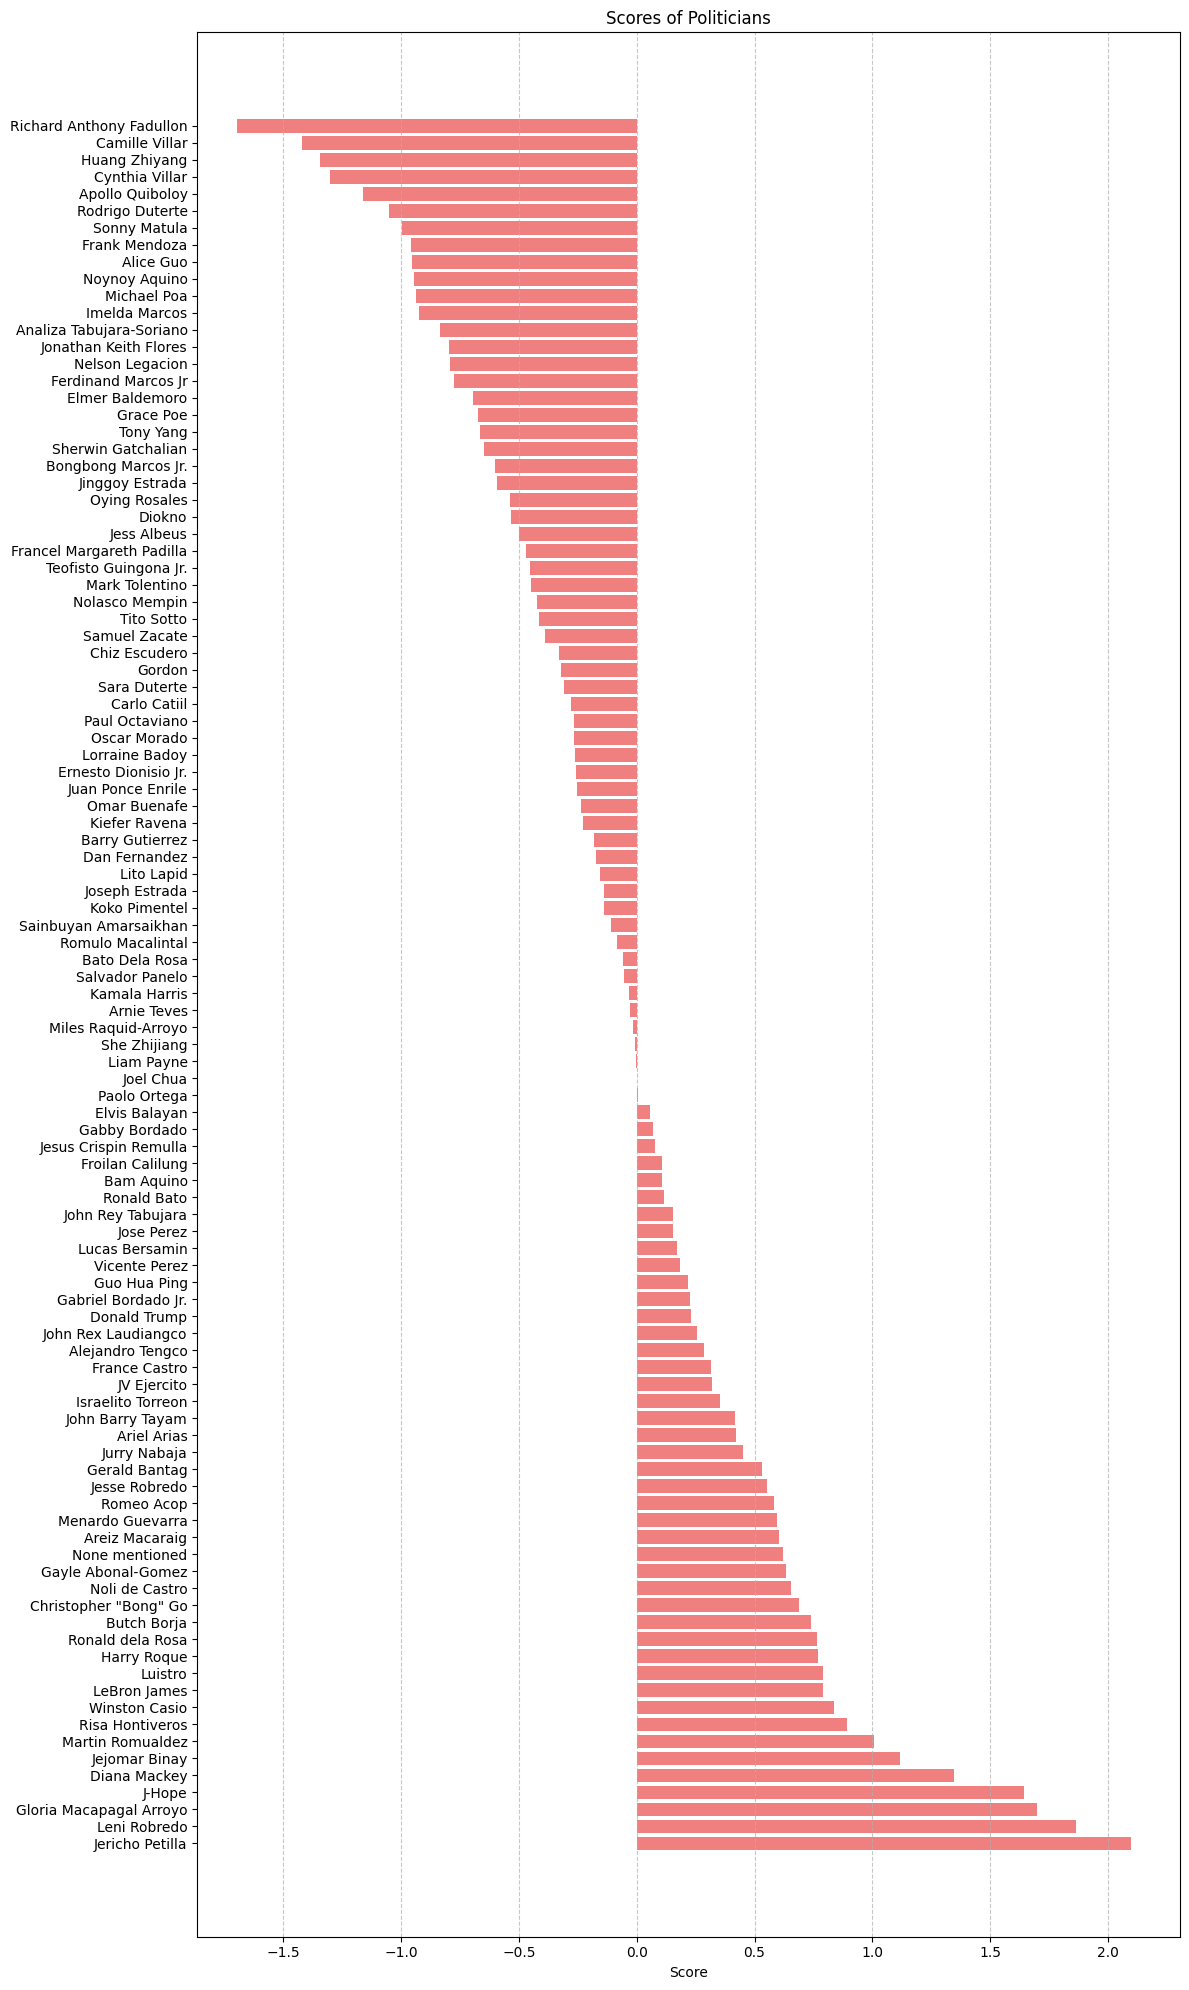

In [193]:
import matplotlib.pyplot as plt

# Print the politician biases log
print(len(model.i_pol.weight))

reps = []
for i in range(num_politicians):
    pol_name = politician_names[i]
    score = (model.i_pol.weight[i].item())
    reps.append((pol_name, score))

reps = sorted(reps, key=lambda x: x[1], reverse=True)
for rep in reps:
    print(rep)



# Unzip the data into two lists
politicians, scores = zip(*reps)

# Create a bar chart
plt.figure(figsize=(12, 20))
plt.barh(politicians, scores, color='lightcoral')
plt.xlabel('Score')
plt.title('Scores of Politicians')
plt.xlim( min(scores)*1.1, max(scores) * 1.1)  # Set xlim for better visualization
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

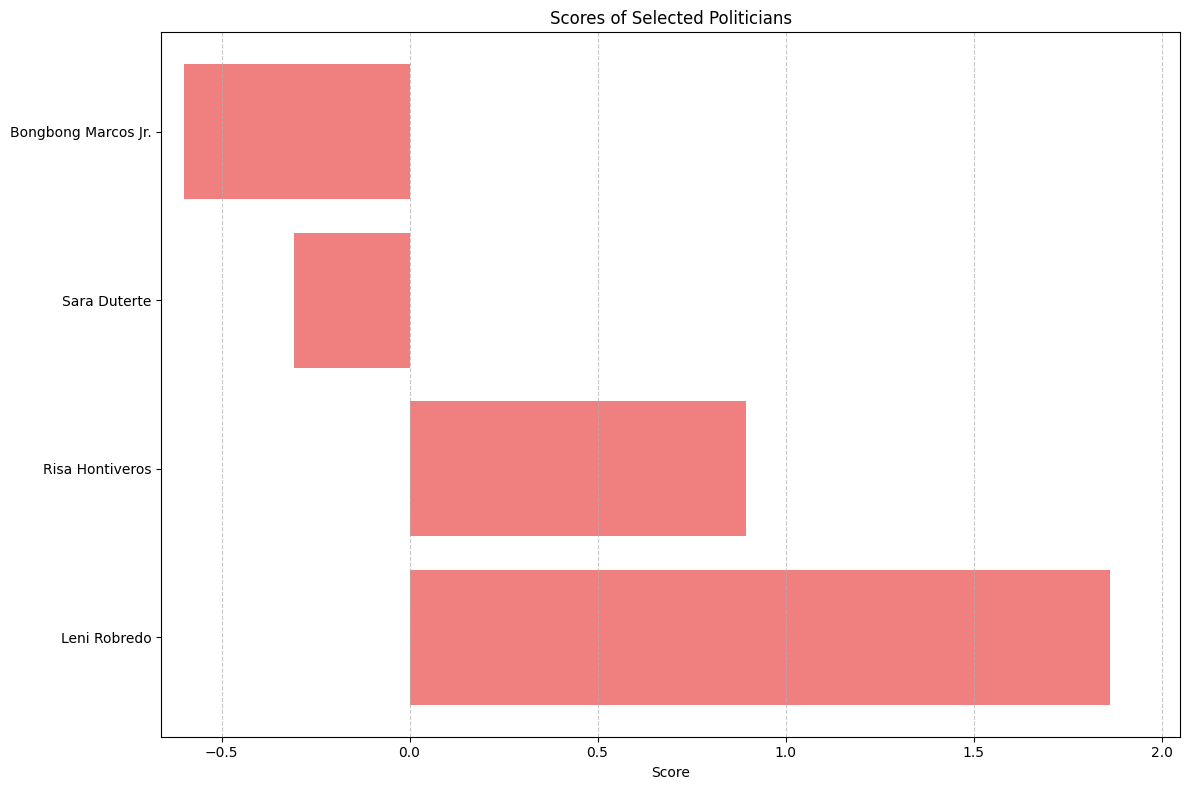

In [194]:
# Whitelist data
whitelist = ['Leni Robredo', 'Risa Hontiveros','Sara Duterte', 'Bongbong Marcos Jr.']

# Filter the data based on the whitelist
filtered_data = [item for item in reps if item[0] in whitelist]

politicians, scores = zip(*filtered_data) if filtered_data else ([], [])

# Create a bar chart
plt.figure(figsize=(12, 8))
plt.barh(politicians, scores, color='lightcoral')
plt.xlabel('Score')
plt.title('Scores of Selected Politicians')
plt.xlim( min(scores)*1.1, max(scores) * 1.1)   # Set xlim for better visualization
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()
